***
<font size="6"><center><b> H-CapsNet: A Capsule Network for Hierarchical Image Classification </b></center></font>
***

# Model Description

**H-CapsNet model:**
- Use Capsule network for hierarchcial classification
- This model contains a deducated feature extraction layer and Capsule netowrk per hierarchy
- For training use MixupData data augmentation technique
- Model Uses Dynamic LossWeight Distribution system
- This model is designed and evaluted using **TensorFlow 2.8.0**

# Import necessary Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K
# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
    # ML model, Dataset and evalution metrics
from src import datasets
from src import DAGdatasets
from src import MLmodel
from src import metrics
from src import MixUp
from src import sysenv
    # For developind (reloades any python scripts)
import importlib

%load_ext autoreload
%autoreload 2

DONE loading Datasets
DONE loading Datasets
DONE loading MixUp Data generator


# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = SARUMAN
• Working Directory = D:\knoor\Deep Learning with Python\RunningOnServer\H-CapsNet\PR-D-22-02168R2
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : D:\knoor\AnacondaEnvironment\py38tf28


In [3]:
## For Using Multiple GPUs
gpus = "0,1" ## Selecting Available gpus
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0,1
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Done: GPU PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
2 Physical GPUs, 2 Logical GPUs


# Training parameters

## Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 32,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"P_Cap_Dim" : 8, # Primary Capsule Dimentions
                "S_Cap_Dim" : 16, # Secondary Capsule Dimention
                "Reconstruction_LW" : 0.0005, # Decoder loss weight
                "class_loss" : MLmodel.MarginLoss(), ## Class prediction loss
                "reconstruction_loss" : 'mse'
               }

## Learning rate decay

In [5]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    return learning_rate_init

# CIFAR-10 Dataset

## Import CIFAR-10 dataset

CIFAR-10 DAG dataset: Training have 50,000 samples and testing have 10,000 samples
dict_keys(['x_train', 'y_train_coarse', 'y_train_medium', 'y_train_fine', 'x_test', 'y_test_coarse', 'y_test_medium', 'y_test_fine', 'tree', 'name'])
INPUT SHAPE: (32, 32, 3) 

TRAIN: 

(50000, 32, 32, 3)
(50000, 10)
(50000, 7)
(50000, 2)

TEST: 

(10000, 32, 32, 3)
(10000, 10)
(10000, 7)
(10000, 2)

Number of Classes in Label Tree: 
Coarse Level =  2 
Medium Level =  7 
Fine Level =  10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

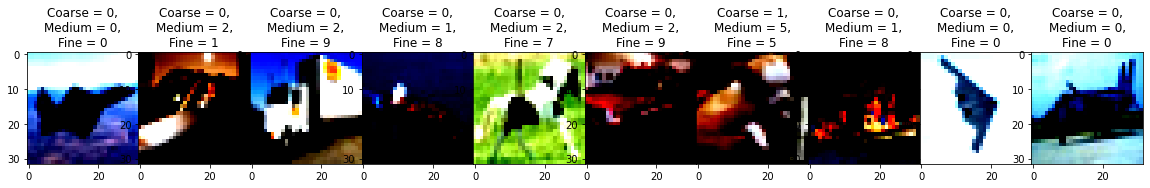

In [6]:
## Import dataset
dataset = DAGdatasets.CIFAR10_DAG()
# dataset = datasets.CIFAR10('reduce')
print(dataset.keys())
# dataset['tree'].show()

input_shape = dataset['x_train'].shape[1:]
print('INPUT SHAPE:',input_shape,'\n')

print("TRAIN: \r\n")
print(dataset['x_train'].shape)
print(dataset['y_train_fine'].shape)
print(dataset['y_train_medium'].shape)
print(dataset['y_train_coarse'].shape)

print("\nTEST: \r\n")
print(dataset['x_test'].shape)
print(dataset['y_test_fine'].shape)
print(dataset['y_test_medium'].shape)
print(dataset['y_test_coarse'].shape)

fine_class = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))
medium_class = len(np.unique(np.argmax(dataset['y_train_medium'], axis=1)))
coarse_class = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
print('\nNumber of Classes in Label Tree:',
      '\nCoarse Level = ',coarse_class,
      '\nMedium Level = ',medium_class,
      '\nFine Level = ',fine_class)
datasets.plot_sample_image(dataset['x_train'],
                           {'coarse':dataset['y_train_coarse'],
                            'medium':dataset['y_train_medium'],
                            'fine':dataset['y_train_fine']})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample = 13
Coarse = [1. 0.]
Medium = [0. 0. 1. 0. 0. 0. 1.]
Fine = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


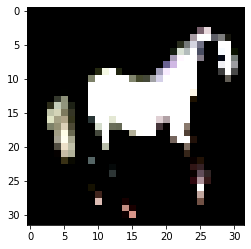

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample = 17
Coarse = [1. 0.]
Medium = [0. 0. 1. 0. 0. 0. 1.]
Fine = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


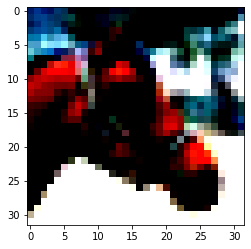

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample = 20
Coarse = [1. 0.]
Medium = [0. 0. 1. 0. 0. 0. 1.]
Fine = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


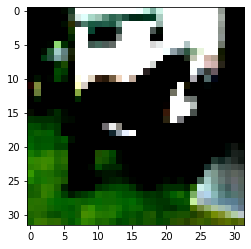

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample = 25
Coarse = [0. 1.]
Medium = [0. 0. 0. 1. 0. 1. 0.]
Fine = [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


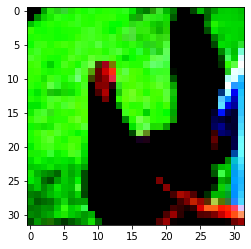

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample = 35
Coarse = [0. 1.]
Medium = [0. 0. 0. 1. 0. 1. 0.]
Fine = [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


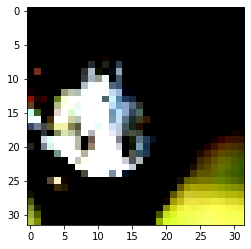

Sample = 48
Coarse = [1. 0.]
Medium = [0. 0. 1. 0. 0. 0. 1.]
Fine = [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


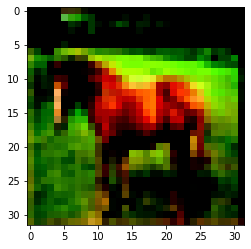

In [7]:
# for i in range(len(dataset['y_train_fine'][:50])):
#     if dataset['y_train_fine'][i][7] == 1 or dataset['y_train_fine'][i][2] == 1:
#         print(f'Sample = {i}')
#         print(f'Coarse = {dataset["y_train_coarse"][i]}')
#         print(f'Medium = {dataset["y_train_medium"][i]}')
#         print(f'Fine = {dataset["y_train_fine"][i]}')
#         plt.imshow(dataset['x_train'][i])
#         plt.show()
#         # plot_images(dataset['x_train'][i], [dataset['y_train_coarse'][i],dataset['y_train_medium'][i],dataset['y_train_fine'][i]])

for i in range(len(dataset['y_test_fine'][:50])):
    if dataset['y_test_fine'][i][7] == 1 or dataset['y_test_fine'][i][2] == 1:
        print(f'Sample = {i}')
        print(f'Coarse = {dataset["y_test_coarse"][i]}')
        print(f'Medium = {dataset["y_test_medium"][i]}')
        print(f'Fine = {dataset["y_test_fine"][i]}')
        plt.imshow(dataset['x_test'][i])
        plt.show()

### Model parameters

In [8]:
initial_lw = MLmodel.initial_lw({"coarse": coarse_class,
                                 "medium": medium_class,
                                 "fine": fine_class})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : model_params['Reconstruction_LW']
             }

def get_compiled_model():
    model = MLmodel.HCapsNet_3_Level(input_shape,
                                     coarse_class, medium_class, fine_class)
    model.compile(optimizer='adam',
                  loss=[model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["class_loss"],
                        model_params["reconstruction_loss"]],
                  loss_weights=[lossweight['coarse_lw'],
                                lossweight['medium_lw'],
                                lossweight['fine_lw'],
                                lossweight['decoder_lw']],
                  metrics={'Fine_prediction_output_layer': 'accuracy',
                           'Medium_prediction_output_layer': 'accuracy',
                           'Coarse_prediction_output_layer': 'accuracy'}
                 )
    return model

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:

                                                                                                  
 FE_conv12 (Conv2D)             (None, 16, 16, 128)  147584      ['batch_normalization_2[0][0]']  
                                                                                                  
 FE_conv24 (Conv2D)             (None, 8, 8, 256)    590080      ['batch_normalization_6[0][0]']  
                                                                                                  
 FE_conv36 (Conv2D)             (None, 4, 4, 512)    2359808     ['batch_normalization_12[0][0]'] 
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 128)  512        ['FE_conv12[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 batch_nor

                                                                  'Decoder_coarse1[0][0]']        
                                                                                                  
 dense_9 (Dense)                (None, 32, 32, 4)    40          ['concatenate[0][0]']            
                                                                                                  
 Final_output (Dense)           (None, 32, 32, 3)    15          ['dense_9[0][0]']                
                                                                                                  
Total params: 18,253,431
Trainable params: 18,247,543
Non-trainable params: 5,888
__________________________________________________________________________________________________


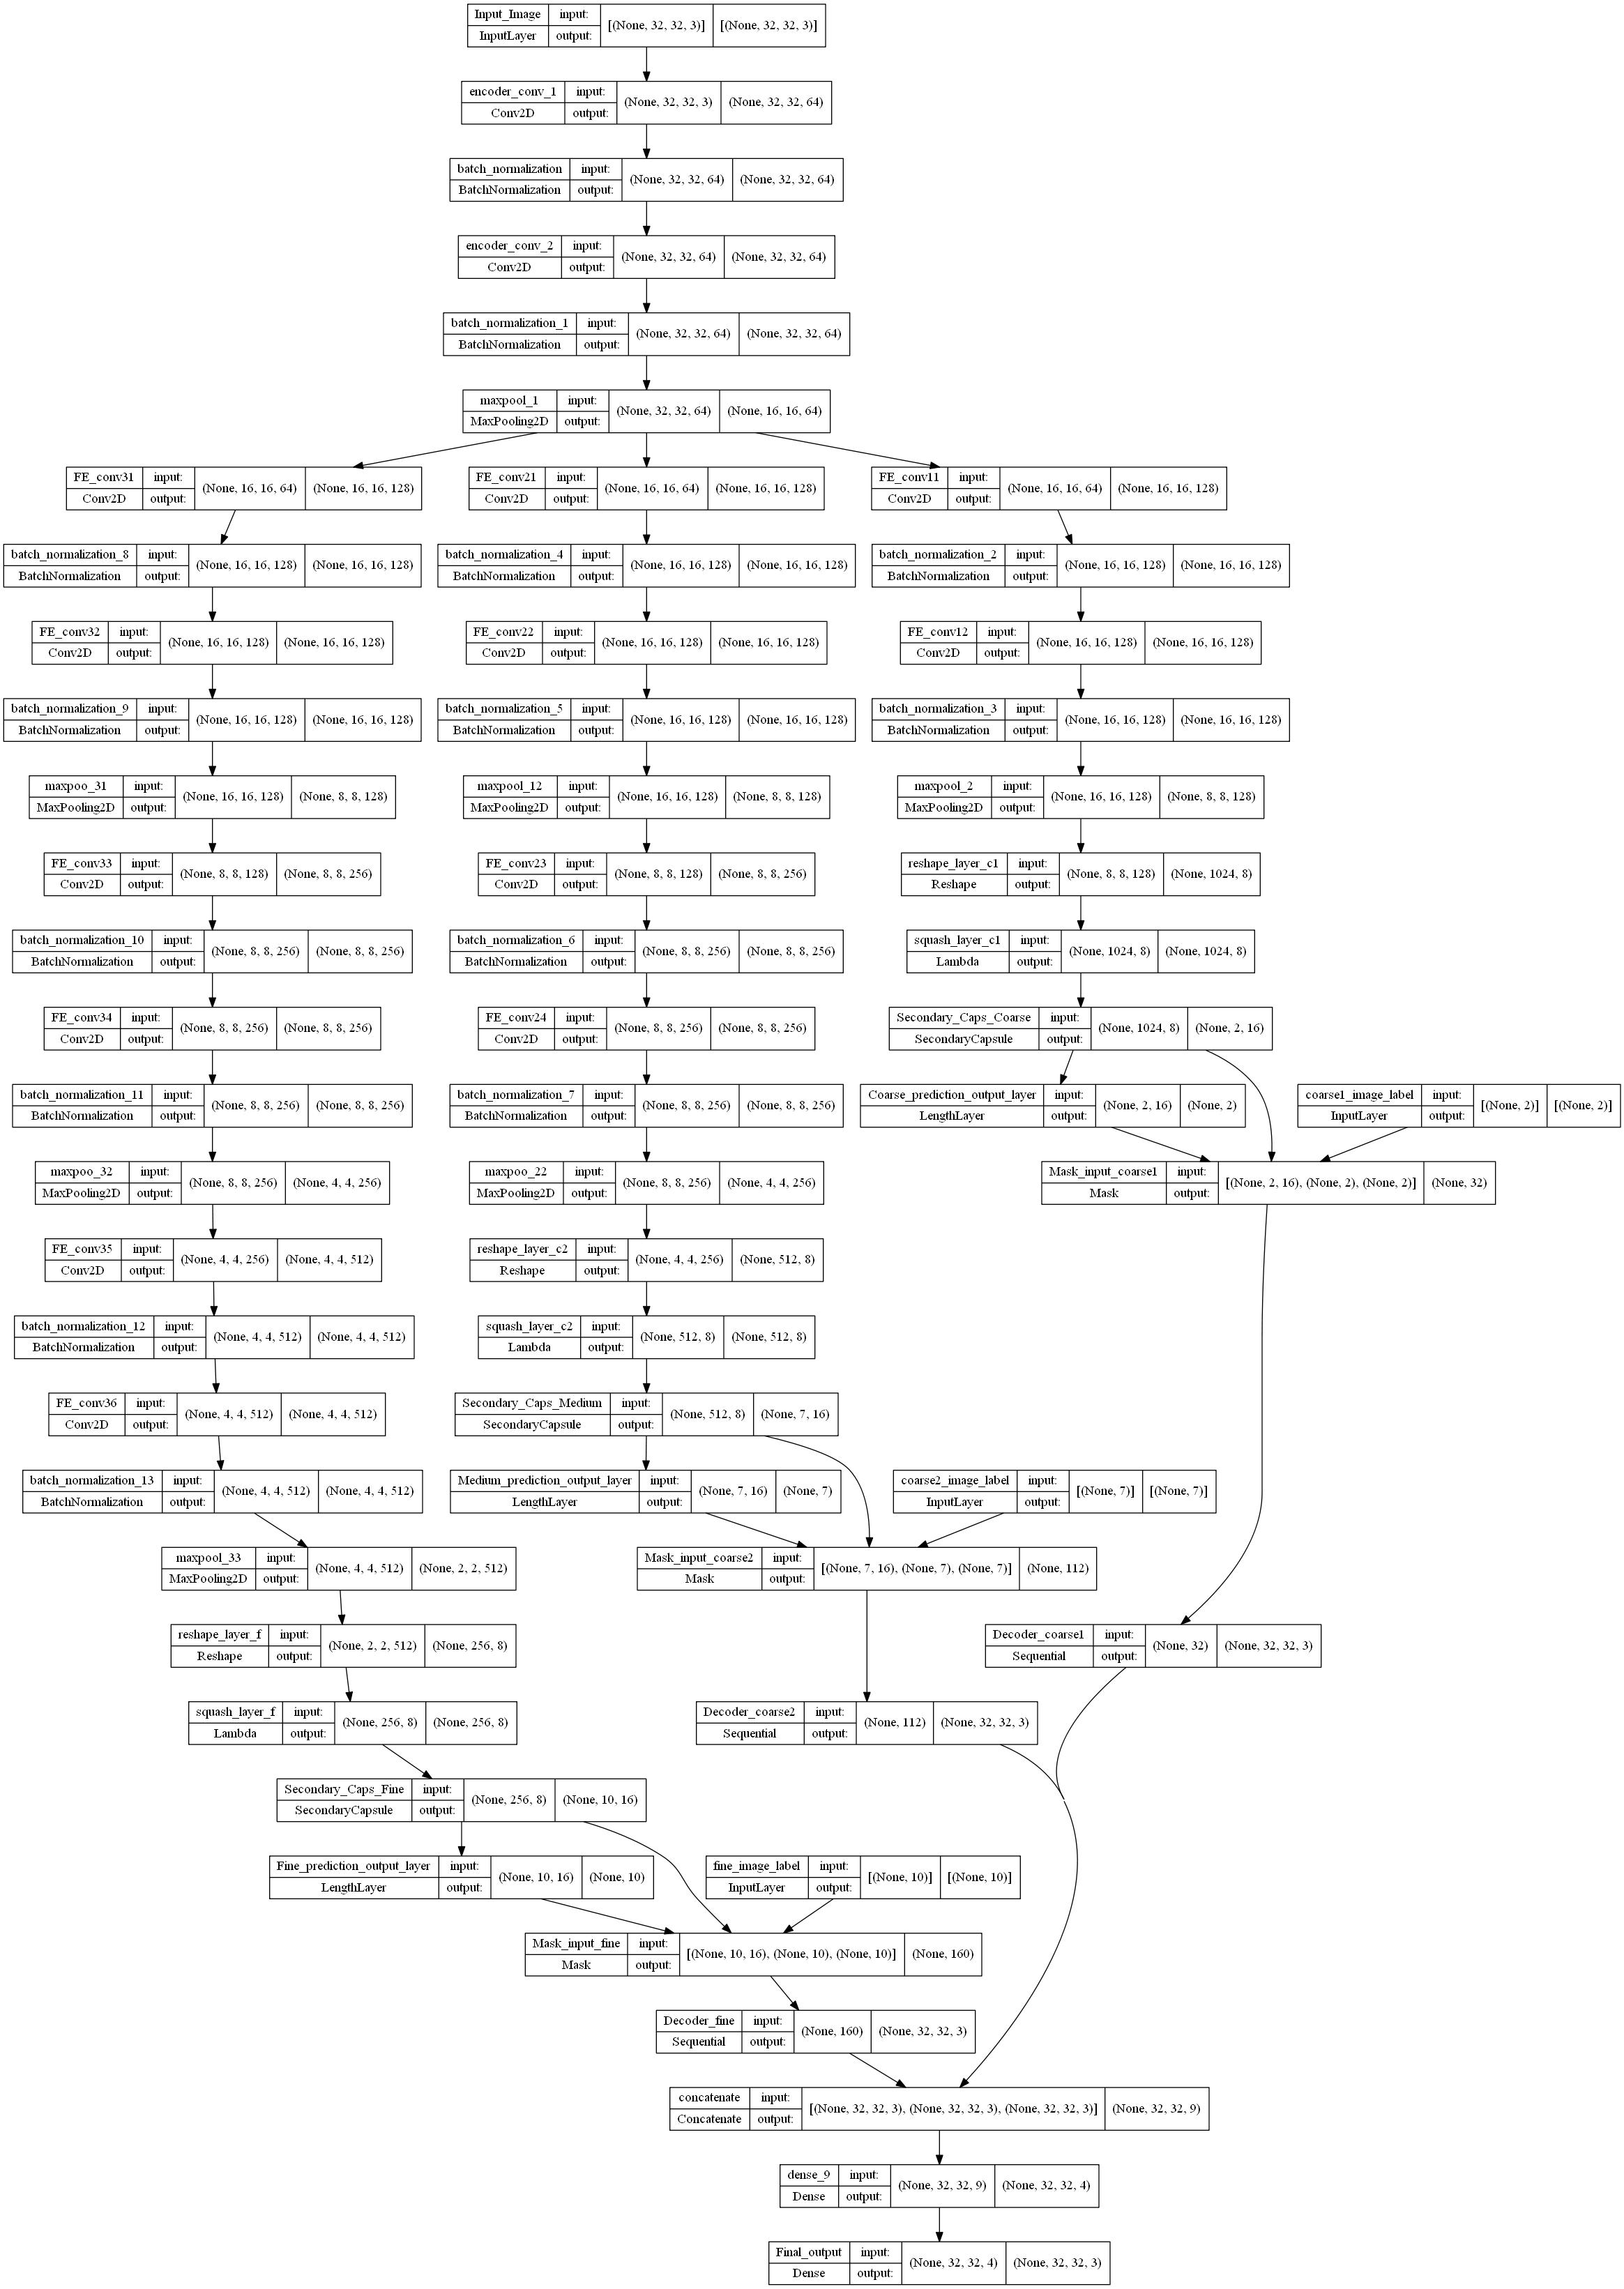

In [9]:
tf.keras.backend.clear_session() ## clear session

# model = get_compiled_model()

#Multiple GPU ------ Windows
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

### Log directory
directory = sysenv.log_dir(dataset["name"]+'/'+model.name)

model.summary()
keras.utils.plot_model(model, to_file = directory+"/H-CapsNet.png", show_shapes=True)

### Callbacks

In [10]:
tb = keras.callbacks.TensorBoard(directory+'/tb_logs')
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch_best.h5',
                                             monitor='val_Fine_prediction_output_layer_accuracy',
                                             save_best_only=True, save_weights_only=True, verbose=1
                                            )

change_lw = MLmodel.LossWeightsModifier(lossweight,
                                        initial_lw,
                                        directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Training Model

In [11]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp.MixupGenerator_3level(dataset['x_train'],
                                                 dataset['y_train_coarse'], 
                                                 dataset['y_train_medium'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

In [12]:
history = model.fit_generator(generator=training_generator,
                              steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                              epochs = train_params["n_epochs"],
                              validation_data = ([dataset['x_test'],
                                                  dataset['y_test_coarse'],
                                                  dataset['y_test_medium'],
                                                  dataset['y_test_fine']],
                                                 [dataset['y_test_coarse'],
                                                  dataset['y_test_medium'],
                                                  dataset['y_test_fine'],
                                                  dataset['x_test']]),
                                  callbacks = [tb,
                                               log,
                                               checkpoint,
                                               lr_decay,
                                               change_lw],
                                  verbose=1)
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.save_weights(model_save_dir)
    print('Trained model saved to = ', model_save_dir)
except:
    print('Model Wight is not saved')

C:\Users\knoor\AppData\Local\Temp\12/ipykernel_26924/1581722819.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=training_generator,


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 81 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 81 all-reduces with algorithm = hierarchical_copy, num_packs = 1
1562/1562 [==============================] - ETA: 0s - loss: 0.2722 - Coarse_prediction_output_layer_loss: 0.1544 - Medium_prediction_output_layer_loss: 0.3563 - Fine_prediction_output_layer_loss: 0.3806 - Final_output_loss: 0.8099 - Coarse_prediction_output_layer_accuracy: 0.7930 - Medium_prediction_output_layer_accuracy: 0.5356 - Fine_prediction_output_layer_accuracy: 0.4725
Epoch 1: val_Fine_prediction_output_layer_accuracy improved from -inf to 0.59360, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 79.30% | Val_Accuracy = 87.55% | LossWeight = 0.25 
  • Medium Accuracy = 53.56% | Val_Accuracy = 62.55% | LossWeight = 0.40 
  • Fine   Accuracy = 47.25% | Val_Accuracy = 59.36% | LossWeight = 0.34 
1562/1562 [==============================] - 1

Epoch 6/100
1562/1562 [==============================] - ETA: 0s - loss: 0.1547 - Coarse_prediction_output_layer_loss: 0.0963 - Medium_prediction_output_layer_loss: 0.1805 - Fine_prediction_output_layer_loss: 0.1754 - Final_output_loss: 0.6246 - Coarse_prediction_output_layer_accuracy: 0.8837 - Medium_prediction_output_layer_accuracy: 0.7466 - Fine_prediction_output_layer_accuracy: 0.8288
Epoch 6: val_Fine_prediction_output_layer_accuracy improved from 0.83660 to 0.84440, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 88.37% | Val_Accuracy = 90.83% | LossWeight = 0.30 
  • Medium Accuracy = 74.66% | Val_Accuracy = 77.57% | LossWeight = 0.46 
  • Fine   Accuracy = 82.88% | Val_Accuracy = 84.44% | LossWeight = 0.23 
1562/1562 [==============================] - 172s 110ms/step - loss: 0.1547 - Coarse_prediction_output_layer_loss: 0.0963 - Medium_prediction_output_layer_loss: 0.1805 - Fine_prediction_output_layer_loss: 0.1754 - Final_output_loss: 0.6246 -

  • Coarse Accuracy = 89.96% | Val_Accuracy = 91.17% | LossWeight = 0.33 
  • Medium Accuracy = 79.84% | Val_Accuracy = 81.12% | LossWeight = 0.47 
  • Fine   Accuracy = 88.51% | Val_Accuracy = 87.40% | LossWeight = 0.20 
1562/1562 [==============================] - 171s 110ms/step - loss: 0.1276 - Coarse_prediction_output_layer_loss: 0.0886 - Medium_prediction_output_layer_loss: 0.1488 - Fine_prediction_output_layer_loss: 0.1401 - Final_output_loss: 0.5834 - Coarse_prediction_output_layer_accuracy: 0.8996 - Medium_prediction_output_layer_accuracy: 0.7984 - Fine_prediction_output_layer_accuracy: 0.8851 - val_loss: 0.0838 - val_Coarse_prediction_output_layer_loss: 0.0665 - val_Medium_prediction_output_layer_loss: 0.0909 - val_Fine_prediction_output_layer_loss: 0.0934 - val_Final_output_loss: 0.7470 - val_Coarse_prediction_output_layer_accuracy: 0.9117 - val_Medium_prediction_output_layer_accuracy: 0.8112 - val_Fine_prediction_output_layer_accuracy: 0.8740 - lr: 9.5000e-04
Epoch 12/100
1

Epoch 17/100
1562/1562 [==============================] - ETA: 0s - loss: 0.1054 - Coarse_prediction_output_layer_loss: 0.0804 - Medium_prediction_output_layer_loss: 0.1212 - Fine_prediction_output_layer_loss: 0.1128 - Final_output_loss: 0.5568 - Coarse_prediction_output_layer_accuracy: 0.9153 - Medium_prediction_output_layer_accuracy: 0.8422 - Fine_prediction_output_layer_accuracy: 0.9254
Epoch 17: val_Fine_prediction_output_layer_accuracy improved from 0.88170 to 0.89390, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 91.53% | Val_Accuracy = 92.71% | LossWeight = 0.36 
  • Medium Accuracy = 84.22% | Val_Accuracy = 84.66% | LossWeight = 0.47 
  • Fine   Accuracy = 92.54% | Val_Accuracy = 89.39% | LossWeight = 0.17 
1562/1562 [==============================] - 171s 110ms/step - loss: 0.1054 - Coarse_prediction_output_layer_loss: 0.0804 - Medium_prediction_output_layer_loss: 0.1212 - Fine_prediction_output_layer_loss: 0.1128 - Final_output_loss: 0.5568

Epoch 23/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0954 - Coarse_prediction_output_layer_loss: 0.0753 - Medium_prediction_output_layer_loss: 0.1090 - Fine_prediction_output_layer_loss: 0.1012 - Final_output_loss: 0.5361 - Coarse_prediction_output_layer_accuracy: 0.9237 - Medium_prediction_output_layer_accuracy: 0.8610 - Fine_prediction_output_layer_accuracy: 0.9429
Epoch 23: val_Fine_prediction_output_layer_accuracy did not improve from 0.89660
  • Coarse Accuracy = 92.37% | Val_Accuracy = 92.96% | LossWeight = 0.37 
  • Medium Accuracy = 86.10% | Val_Accuracy = 86.09% | LossWeight = 0.48 
  • Fine   Accuracy = 94.29% | Val_Accuracy = 89.47% | LossWeight = 0.15 
1562/1562 [==============================] - 171s 109ms/step - loss: 0.0954 - Coarse_prediction_output_layer_loss: 0.0753 - Medium_prediction_output_layer_loss: 0.1090 - Fine_prediction_output_layer_loss: 0.1012 - Final_output_loss: 0.5361 - Coarse_prediction_output_layer_accuracy: 0.9237 - Medium_predi

Epoch 29/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0908 - Coarse_prediction_output_layer_loss: 0.0723 - Medium_prediction_output_layer_loss: 0.1032 - Fine_prediction_output_layer_loss: 0.0966 - Final_output_loss: 0.5221 - Coarse_prediction_output_layer_accuracy: 0.9292 - Medium_prediction_output_layer_accuracy: 0.8716 - Fine_prediction_output_layer_accuracy: 0.9484
Epoch 29: val_Fine_prediction_output_layer_accuracy did not improve from 0.90470
  • Coarse Accuracy = 92.92% | Val_Accuracy = 93.83% | LossWeight = 0.37 
  • Medium Accuracy = 87.16% | Val_Accuracy = 86.47% | LossWeight = 0.48 
  • Fine   Accuracy = 94.84% | Val_Accuracy = 90.02% | LossWeight = 0.14 
1562/1562 [==============================] - 168s 108ms/step - loss: 0.0908 - Coarse_prediction_output_layer_loss: 0.0723 - Medium_prediction_output_layer_loss: 0.1032 - Fine_prediction_output_layer_loss: 0.0966 - Final_output_loss: 0.5221 - Coarse_prediction_output_layer_accuracy: 0.9292 - Medium_predi

Epoch 35/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0865 - Coarse_prediction_output_layer_loss: 0.0697 - Medium_prediction_output_layer_loss: 0.0979 - Fine_prediction_output_layer_loss: 0.0919 - Final_output_loss: 0.5047 - Coarse_prediction_output_layer_accuracy: 0.9342 - Medium_prediction_output_layer_accuracy: 0.8815 - Fine_prediction_output_layer_accuracy: 0.9553
Epoch 35: val_Fine_prediction_output_layer_accuracy improved from 0.90770 to 0.90880, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 93.42% | Val_Accuracy = 94.11% | LossWeight = 0.38 
  • Medium Accuracy = 88.15% | Val_Accuracy = 86.64% | LossWeight = 0.48 
  • Fine   Accuracy = 95.53% | Val_Accuracy = 90.88% | LossWeight = 0.14 
1562/1562 [==============================] - 171s 109ms/step - loss: 0.0865 - Coarse_prediction_output_layer_loss: 0.0697 - Medium_prediction_output_layer_loss: 0.0979 - Fine_prediction_output_layer_loss: 0.0919 - Final_output_loss: 0.5047

Epoch 41/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0846 - Coarse_prediction_output_layer_loss: 0.0679 - Medium_prediction_output_layer_loss: 0.0958 - Fine_prediction_output_layer_loss: 0.0902 - Final_output_loss: 0.4906 - Coarse_prediction_output_layer_accuracy: 0.9366 - Medium_prediction_output_layer_accuracy: 0.8853 - Fine_prediction_output_layer_accuracy: 0.9575
Epoch 41: val_Fine_prediction_output_layer_accuracy did not improve from 0.90880
  • Coarse Accuracy = 93.66% | Val_Accuracy = 93.75% | LossWeight = 0.38 
  • Medium Accuracy = 88.53% | Val_Accuracy = 88.01% | LossWeight = 0.49 
  • Fine   Accuracy = 95.75% | Val_Accuracy = 90.84% | LossWeight = 0.13 
1562/1562 [==============================] - 170s 109ms/step - loss: 0.0846 - Coarse_prediction_output_layer_loss: 0.0679 - Medium_prediction_output_layer_loss: 0.0958 - Fine_prediction_output_layer_loss: 0.0902 - Final_output_loss: 0.4906 - Coarse_prediction_output_layer_accuracy: 0.9366 - Medium_predi

Epoch 47/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0838 - Coarse_prediction_output_layer_loss: 0.0674 - Medium_prediction_output_layer_loss: 0.0946 - Fine_prediction_output_layer_loss: 0.0893 - Final_output_loss: 0.4787 - Coarse_prediction_output_layer_accuracy: 0.9388 - Medium_prediction_output_layer_accuracy: 0.8867 - Fine_prediction_output_layer_accuracy: 0.9565
Epoch 47: val_Fine_prediction_output_layer_accuracy did not improve from 0.91130
  • Coarse Accuracy = 93.88% | Val_Accuracy = 94.26% | LossWeight = 0.37 
  • Medium Accuracy = 88.67% | Val_Accuracy = 87.81% | LossWeight = 0.49 
  • Fine   Accuracy = 95.65% | Val_Accuracy = 91.02% | LossWeight = 0.14 
1562/1562 [==============================] - 169s 108ms/step - loss: 0.0838 - Coarse_prediction_output_layer_loss: 0.0674 - Medium_prediction_output_layer_loss: 0.0946 - Fine_prediction_output_layer_loss: 0.0893 - Final_output_loss: 0.4787 - Coarse_prediction_output_layer_accuracy: 0.9388 - Medium_predi

Epoch 53/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0824 - Coarse_prediction_output_layer_loss: 0.0661 - Medium_prediction_output_layer_loss: 0.0931 - Fine_prediction_output_layer_loss: 0.0872 - Final_output_loss: 0.4695 - Coarse_prediction_output_layer_accuracy: 0.9411 - Medium_prediction_output_layer_accuracy: 0.8884 - Fine_prediction_output_layer_accuracy: 0.9620
Epoch 53: val_Fine_prediction_output_layer_accuracy did not improve from 0.91220
  • Coarse Accuracy = 94.11% | Val_Accuracy = 94.43% | LossWeight = 0.37 
  • Medium Accuracy = 88.84% | Val_Accuracy = 87.60% | LossWeight = 0.50 
  • Fine   Accuracy = 96.20% | Val_Accuracy = 91.09% | LossWeight = 0.13 
1562/1562 [==============================] - 169s 108ms/step - loss: 0.0824 - Coarse_prediction_output_layer_loss: 0.0661 - Medium_prediction_output_layer_loss: 0.0931 - Fine_prediction_output_layer_loss: 0.0872 - Final_output_loss: 0.4695 - Coarse_prediction_output_layer_accuracy: 0.9411 - Medium_predi

Epoch 59/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0820 - Coarse_prediction_output_layer_loss: 0.0658 - Medium_prediction_output_layer_loss: 0.0924 - Fine_prediction_output_layer_loss: 0.0872 - Final_output_loss: 0.4656 - Coarse_prediction_output_layer_accuracy: 0.9407 - Medium_prediction_output_layer_accuracy: 0.8921 - Fine_prediction_output_layer_accuracy: 0.9586
Epoch 59: val_Fine_prediction_output_layer_accuracy did not improve from 0.91310
  • Coarse Accuracy = 94.07% | Val_Accuracy = 94.18% | LossWeight = 0.38 
  • Medium Accuracy = 89.21% | Val_Accuracy = 87.36% | LossWeight = 0.48 
  • Fine   Accuracy = 95.86% | Val_Accuracy = 91.17% | LossWeight = 0.14 
1562/1562 [==============================] - 171s 110ms/step - loss: 0.0820 - Coarse_prediction_output_layer_loss: 0.0658 - Medium_prediction_output_layer_loss: 0.0924 - Fine_prediction_output_layer_loss: 0.0872 - Final_output_loss: 0.4656 - Coarse_prediction_output_layer_accuracy: 0.9407 - Medium_predi

Epoch 65/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0807 - Coarse_prediction_output_layer_loss: 0.0649 - Medium_prediction_output_layer_loss: 0.0909 - Fine_prediction_output_layer_loss: 0.0856 - Final_output_loss: 0.4663 - Coarse_prediction_output_layer_accuracy: 0.9421 - Medium_prediction_output_layer_accuracy: 0.8919 - Fine_prediction_output_layer_accuracy: 0.9627
Epoch 65: val_Fine_prediction_output_layer_accuracy improved from 0.91460 to 0.91490, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 94.21% | Val_Accuracy = 94.43% | LossWeight = 0.38 
  • Medium Accuracy = 89.19% | Val_Accuracy = 88.43% | LossWeight = 0.50 
  • Fine   Accuracy = 96.27% | Val_Accuracy = 91.49% | LossWeight = 0.13 
1562/1562 [==============================] - 172s 110ms/step - loss: 0.0807 - Coarse_prediction_output_layer_loss: 0.0649 - Medium_prediction_output_layer_loss: 0.0909 - Fine_prediction_output_layer_loss: 0.0856 - Final_output_loss: 0.4663

Epoch 71/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0814 - Coarse_prediction_output_layer_loss: 0.0649 - Medium_prediction_output_layer_loss: 0.0915 - Fine_prediction_output_layer_loss: 0.0867 - Final_output_loss: 0.4584 - Coarse_prediction_output_layer_accuracy: 0.9440 - Medium_prediction_output_layer_accuracy: 0.8905 - Fine_prediction_output_layer_accuracy: 0.9599
Epoch 71: val_Fine_prediction_output_layer_accuracy did not improve from 0.91560
  • Coarse Accuracy = 94.40% | Val_Accuracy = 94.16% | LossWeight = 0.36 
  • Medium Accuracy = 89.05% | Val_Accuracy = 87.99% | LossWeight = 0.50 
  • Fine   Accuracy = 95.99% | Val_Accuracy = 91.45% | LossWeight = 0.14 
1562/1562 [==============================] - 191s 122ms/step - loss: 0.0814 - Coarse_prediction_output_layer_loss: 0.0649 - Medium_prediction_output_layer_loss: 0.0915 - Fine_prediction_output_layer_loss: 0.0867 - Final_output_loss: 0.4584 - Coarse_prediction_output_layer_accuracy: 0.9440 - Medium_predi

Epoch 77/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0808 - Coarse_prediction_output_layer_loss: 0.0647 - Medium_prediction_output_layer_loss: 0.0907 - Fine_prediction_output_layer_loss: 0.0860 - Final_output_loss: 0.4562 - Coarse_prediction_output_layer_accuracy: 0.9433 - Medium_prediction_output_layer_accuracy: 0.8905 - Fine_prediction_output_layer_accuracy: 0.9614
Epoch 77: val_Fine_prediction_output_layer_accuracy improved from 0.91560 to 0.91610, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 94.33% | Val_Accuracy = 94.42% | LossWeight = 0.37 
  • Medium Accuracy = 89.05% | Val_Accuracy = 87.68% | LossWeight = 0.50 
  • Fine   Accuracy = 96.14% | Val_Accuracy = 91.61% | LossWeight = 0.13 
1562/1562 [==============================] - 186s 119ms/step - loss: 0.0808 - Coarse_prediction_output_layer_loss: 0.0647 - Medium_prediction_output_layer_loss: 0.0907 - Fine_prediction_output_layer_loss: 0.0860 - Final_output_loss: 0.4562

Epoch 83/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0804 - Coarse_prediction_output_layer_loss: 0.0643 - Medium_prediction_output_layer_loss: 0.0901 - Fine_prediction_output_layer_loss: 0.0850 - Final_output_loss: 0.4557 - Coarse_prediction_output_layer_accuracy: 0.9446 - Medium_prediction_output_layer_accuracy: 0.8924 - Fine_prediction_output_layer_accuracy: 0.9628
Epoch 83: val_Fine_prediction_output_layer_accuracy improved from 0.91640 to 0.91690, saving model to ./logs/CIFAR-10_DAG/H-CapsNet\epoch_best.h5
  • Coarse Accuracy = 94.46% | Val_Accuracy = 94.50% | LossWeight = 0.37 
  • Medium Accuracy = 89.24% | Val_Accuracy = 88.03% | LossWeight = 0.50 
  • Fine   Accuracy = 96.28% | Val_Accuracy = 91.69% | LossWeight = 0.13 
1562/1562 [==============================] - 172s 110ms/step - loss: 0.0804 - Coarse_prediction_output_layer_loss: 0.0643 - Medium_prediction_output_layer_loss: 0.0901 - Fine_prediction_output_layer_loss: 0.0850 - Final_output_loss: 0.4557

Epoch 89/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0799 - Coarse_prediction_output_layer_loss: 0.0639 - Medium_prediction_output_layer_loss: 0.0900 - Fine_prediction_output_layer_loss: 0.0846 - Final_output_loss: 0.4532 - Coarse_prediction_output_layer_accuracy: 0.9452 - Medium_prediction_output_layer_accuracy: 0.8931 - Fine_prediction_output_layer_accuracy: 0.9639
Epoch 89: val_Fine_prediction_output_layer_accuracy did not improve from 0.91690
  • Coarse Accuracy = 94.52% | Val_Accuracy = 94.39% | LossWeight = 0.37 
  • Medium Accuracy = 89.31% | Val_Accuracy = 88.06% | LossWeight = 0.50 
  • Fine   Accuracy = 96.39% | Val_Accuracy = 91.42% | LossWeight = 0.13 
1562/1562 [==============================] - 189s 121ms/step - loss: 0.0799 - Coarse_prediction_output_layer_loss: 0.0639 - Medium_prediction_output_layer_loss: 0.0900 - Fine_prediction_output_layer_loss: 0.0846 - Final_output_loss: 0.4532 - Coarse_prediction_output_layer_accuracy: 0.9452 - Medium_predi

Epoch 95/100
1562/1562 [==============================] - ETA: 0s - loss: 0.0797 - Coarse_prediction_output_layer_loss: 0.0633 - Medium_prediction_output_layer_loss: 0.0896 - Fine_prediction_output_layer_loss: 0.0849 - Final_output_loss: 0.4512 - Coarse_prediction_output_layer_accuracy: 0.9468 - Medium_prediction_output_layer_accuracy: 0.8940 - Fine_prediction_output_layer_accuracy: 0.9611
Epoch 95: val_Fine_prediction_output_layer_accuracy did not improve from 0.91690
  • Coarse Accuracy = 94.68% | Val_Accuracy = 94.37% | LossWeight = 0.36 
  • Medium Accuracy = 89.40% | Val_Accuracy = 88.24% | LossWeight = 0.50 
  • Fine   Accuracy = 96.11% | Val_Accuracy = 91.54% | LossWeight = 0.14 
1562/1562 [==============================] - 184s 118ms/step - loss: 0.0797 - Coarse_prediction_output_layer_loss: 0.0633 - Medium_prediction_output_layer_loss: 0.0896 - Fine_prediction_output_layer_loss: 0.0849 - Final_output_loss: 0.4512 - Coarse_prediction_output_layer_accuracy: 0.9468 - Medium_predi

Trained model saved to =  ./logs/CIFAR-10_DAG/H-CapsNet/trained_model.h5


## Model Analysis

157/157 [==============================] - 7s 45ms/step - loss: 0.0562 - Coarse_prediction_output_layer_loss: 0.0435 - Medium_prediction_output_layer_loss: 0.0629 - Fine_prediction_output_layer_loss: 0.0640 - Final_output_loss: 0.6071 - Coarse_prediction_output_layer_accuracy: 0.9439 - Medium_prediction_output_layer_accuracy: 0.8806 - Fine_prediction_output_layer_accuracy: 0.9159
1. loss ==> 0.0562158077955246
2. Coarse_prediction_output_layer_loss ==> 0.04348883032798767
3. Medium_prediction_output_layer_loss ==> 0.06285630166530609
4. Fine_prediction_output_layer_loss ==> 0.06397398561239243
5. Final_output_loss ==> 0.6071051955223083
6. Coarse_prediction_output_layer_accuracy ==> 0.9438999891281128
7. Medium_prediction_output_layer_accuracy ==> 0.8805999755859375
8. Fine_prediction_output_layer_accuracy ==> 0.9158999919891357
157/157 [==============================] - 6s 34ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

  • Confusion_Matrix 

  • COARSE LEVEL 
[[4718  282]
 [ 279 4721]]

  • MEDIUM LEVEL 
[[ 912   19   28    6    4   28    3]
 [  23  950   17    0    0    8    2]
 [  14    7 2649    2    4   49  275]
 [  27    5    9  588   14  329   28]
 [   4    0    3    3  944   43    3]
 [  11    7   24    2   36 1861   59]
 [   3    1    3    4   17   70  902]]

  • FINE LEVEL 
[[944   1  12   1   1   0   6   5  21   9]
 [  1 977   0   0   0   0   0   0   2  20]
 [ 30   2 877  26  17  15  18  11   2   2]
 [ 12   3  31 800  20  69  41  11   4   9]
 [  2   0  20  13 927   9  21   7   1   0]
 [ 10   2  17  77  17 854  10  12   0   1]
 [  6   1  18  11   6   4 952   0   0   2]
 [  7   0  11  13  20  11   1 934   2   1]
 [ 31  11   5   1   0   1   0   1 943   7]
 [  9  31   0   1   1   0   2   0   5 951]]

  • Classification Report 


  • COARSE LEVEL 


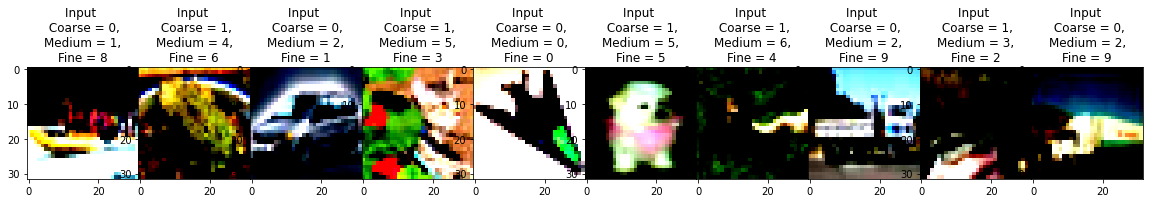

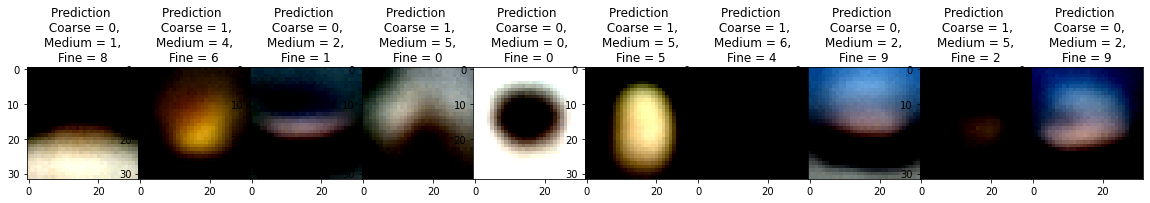

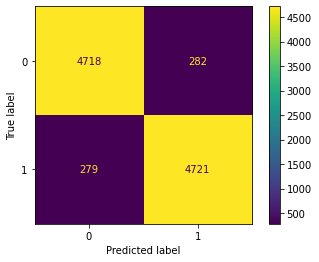

              precision    recall  f1-score   support

           0    0.94417   0.94360   0.94388      5000
           1    0.94363   0.94420   0.94392      5000

    accuracy                        0.94390     10000
   macro avg    0.94390   0.94390   0.94390     10000
weighted avg    0.94390   0.94390   0.94390     10000


  • MEDIUM LEVEL 


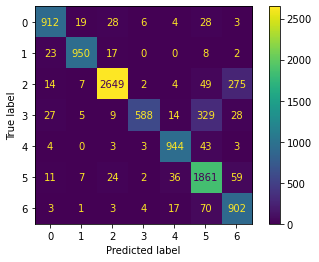

              precision    recall  f1-score   support

           0    0.91751   0.91200   0.91474      1000
           1    0.96057   0.95000   0.95525      1000
           2    0.96926   0.88300   0.92412      3000
           3    0.97190   0.58800   0.73271      1000
           4    0.92640   0.94400   0.93512      1000
           5    0.77931   0.93050   0.84822      2000
           6    0.70912   0.90200   0.79401      1000

    accuracy                        0.88060     10000
   macro avg    0.89058   0.87279   0.87203     10000
weighted avg    0.89519   0.88060   0.88007     10000


  • FINE LEVEL 


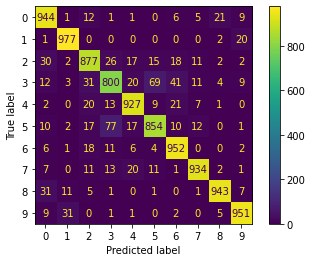

              precision    recall  f1-score   support

           0    0.89734   0.94400   0.92008      1000
           1    0.95039   0.97700   0.96351      1000
           2    0.88496   0.87700   0.88096      1000
           3    0.84836   0.80000   0.82347      1000
           4    0.91873   0.92700   0.92285      1000
           5    0.88681   0.85400   0.87010      1000
           6    0.90580   0.95200   0.92833      1000
           7    0.95209   0.93400   0.94296      1000
           8    0.96224   0.94300   0.95253      1000
           9    0.94910   0.95100   0.95005      1000

    accuracy                        0.91590     10000
   macro avg    0.91558   0.91590   0.91548     10000
weighted avg    0.91558   0.91590   0.91548     10000



In [15]:
model_analysis = MLmodel.model_analysis(model, dataset)

results = model_analysis.evaluate()

predictions = model_analysis.prediction()

true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1],predictions[2]]
metrics.lvl_wise_metric(true_label,pred_label)

In [14]:
from src import metricsDAG

h_measurements = metricsDAG.hierarchical_metrics([dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']],
                                            [predictions[0],predictions[1],predictions[2]])
# Print the h_measurements dictionary in a nice format
print(*[f'\n{key} = {value}\n' for key, value in h_measurements.items()])


hierarchical precision = 0.9222166666666691
 
hierarchical recall = 0.927450000000002
 
hierarchical f1 = 0.924825929897281
 
hierarchical consistency = 0.9034
 
hierarchical exact match = 0.8078

